In [1]:
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset,DataLoader
import torch
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel import ecat

In [2]:
class ScanDataSet(Dataset):
    def __init__(self, image_root,label_root,filetype):
        self.image_root = image_root
        self.label_root = label_root
        self.filetype = filetype #indicates which kind of scan, use ""
        self.samples = []
        
        self.disease = LabelEncoder()
        self._init_dataset()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        scan, disease = self.samples[idx]
        return scan,disease

    def _init_dataset(self):
        
        #Read the disaese
        tmp_df = pd.read_csv(self.label_root)
        
        labels = tmp_df.Label.astype(np.int64) #Integer labels
        one_hot_encode = list()
        for value in labels:
            letter = [0 for _ in range(0,6)]
            letter[value] = 1
            one_hot_encode.append(letter)
        diseases = np.array(one_hot_encode)
        self.disease = diseases
        
        #Reads the scans
        listFilesECAT = [] #create an empty list
        for dirName, subdirList, fileList in os.walk(self.image_root):
            for filename in fileList:
                if self.filetype in filename.lower(): #check wheter the file's ECAT
                    listFilesECAT.append(os.path.join(dirName, filename))
        
        listFilesECAT.sort()

        refImg = ecat.load(listFilesECAT[0]).get_frame(0)

        #Create an array to store the scans of all the patients
        images = np.zeros((np.shape(refImg)[0],np.shape(refImg)[1],np.shape(refImg)[2]))
        images = images[...,np.newaxis]
        for nr in range(np.size(listFilesECAT)):
            images = ecat.load(listFilesECAT[nr]).get_frame(0)
            images = images[...,np.newaxis]
            images = torch.from_numpy(images)
            self.samples.append((images,diseases[nr,:]))
                
    

In [3]:
def show_scan(sample,sliceNr=63):
    image = sample[0]
    label = sample[1]
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    axs[0, 0].imshow(image[:,:,sliceNr]) #SUVr
    axs[0, 0].set_title(['Patient 1: SUVr (PET) slice ', sliceNr])
    axs[0, 1].imshow(images[:,:,sliceNr, (patient1-1)*2+1]) #rCBF
    axs[0, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr])
    axs[1, 0].imshow(images[:,:,sliceNr, (patient2-1)*2]) #SUVr
    axs[1, 0].set_title(['Patient 2: SUVr (PET) slice ', sliceNr])
    axs[1, 1].imshow(images[:,:,sliceNr, (patient2-1)*2+1]) #rCBF
    axs[1, 1].set_title(['Patient 2: rCBF (SPECT) slice ', sliceNr])

In [3]:
image_root = 'projectfiles_PE2I/scans/ecat_scans/'
label_root = 'projectfiles_PE2I/patientlist.csv'
filetype = "1.v"
datasetSUV = ScanDataSet(image_root,label_root,filetype)

filetype = "f.v"
datasetCBF = ScanDataSet(image_root,label_root,filetype)

dataloader = DataLoader(datasetSUV, batch_size=4,
                        shuffle=True, num_workers=4)

torch.Size([128, 128, 128, 1])
torch.Size([128, 128, 128, 1])
[61 50 73]
torch.Size([80, 80, 40])
torch.Size([128, 128, 128])


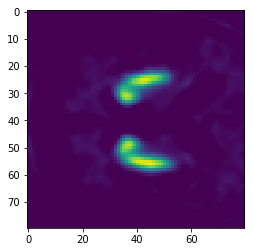

In [56]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt


print((dataset[1][0]).size())
#vals,index=torch.max(dataset[1][0],3)
sample=datasetSUV.__getitem__(1)

print(sample[0].size())
image=np.squeeze(sample[0])


val = torch.max(image) -torch.max(image)*0.1

position1 = np.where(image > val)
x=position1[0][:]
y=position1[1][:]
z=position1[2][:]
#Get middle position of the two balls
#Locate x-position
threshold = (np.max(x)+np.min(x))/2
index= x<= threshold
xmid=(np.mean(x[index])+np.mean(x[~index]))/2
ymid=np.mean(y).astype(int)
zmid=np.mean(z).astype(int)

#Point between balls
position=np.array([xmid,ymid,zmid]).astype(int)
print(position)


# Manually perform some crop
nrPixelsxy = 40
nrPixelsz=20

cropped  = image[position[0]-nrPixelsxy:position[0]+nrPixelsxy, position[1]-nrPixelsxy:position[1]+nrPixelsxy, position[2]-nrPixelsz:position[2]+nrPixelsz]
print(cropped.size())
plt.imshow(cropped[:,:,19])
print(image.size())


torch.Size([128, 128, 128, 1])
torch.Size([128, 128, 128])


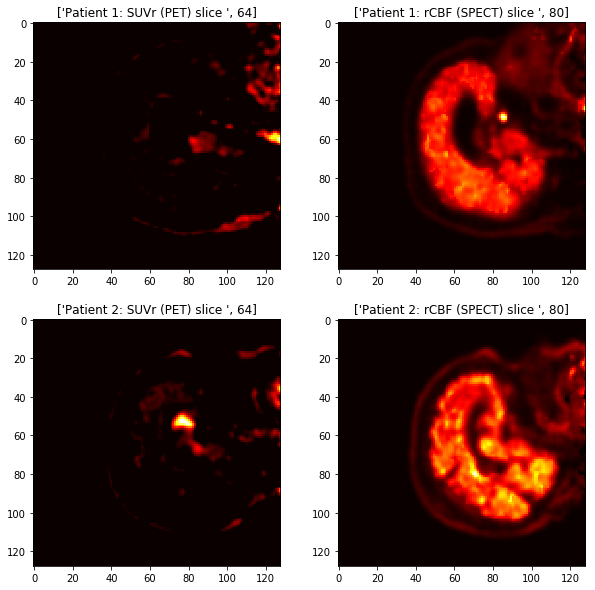

In [28]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize=(10,10))


sample1=datasetSUV.__getitem__(1)
sample2=datasetCBF.__getitem__(1)
sample3=datasetSUV.__getitem__(3)
sample4=datasetCBF.__getitem__(3)
print(sample[0].size())
image1=np.squeeze(sample1[0])
image2=np.squeeze(sample2[0])  
image3=np.squeeze(sample3[0])
image4=np.squeeze(sample4[0]) 
print(image1.size())
sliceNr1=64
sliceNr2=80
                        
axs[0, 0].imshow(image1[61,:,:],cmap='hot') #SUVr 
axs[0, 0].set_title(['Patient 1: SUVr (PET) slice ', sliceNr1])
axs[0, 1].imshow(image2[61,:,:],cmap='hot') #SUVr
axs[0, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[1, 0].imshow(image3[60,:,:],cmap='hot') #SUVr 
axs[1, 0].set_title(['Patient 2: SUVr (PET) slice ', sliceNr1])
axs[1, 1].imshow(image4[60,:,:],cmap='hot') #SUVr
axs[1, 1].set_title(['Patient 2: rCBF (SPECT) slice ', sliceNr2])
plt.show()

<IPython.core.display.Javascript object>


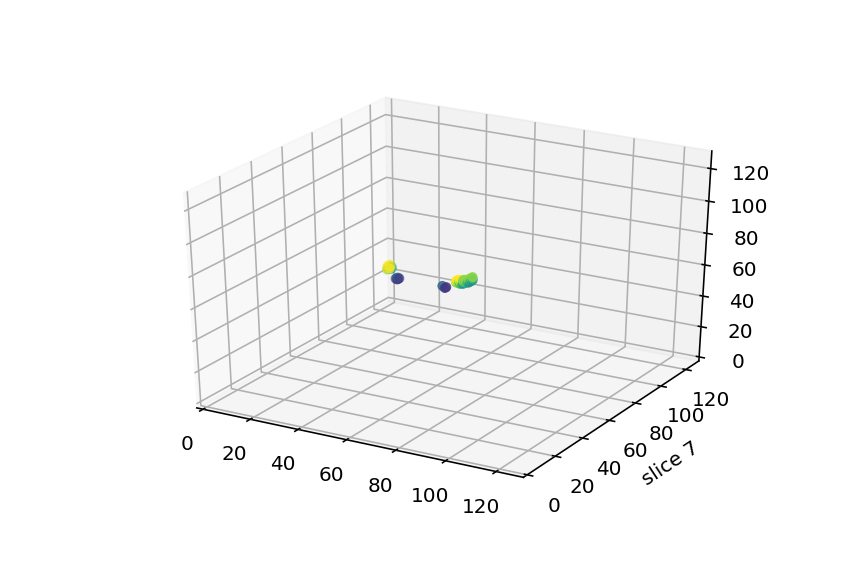

(0, 128)

In [19]:
#print(np.shape(position))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x,y,z, c=z, cmap='viridis', linewidth=0.5);
ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)

<IPython.core.display.Javascript object>


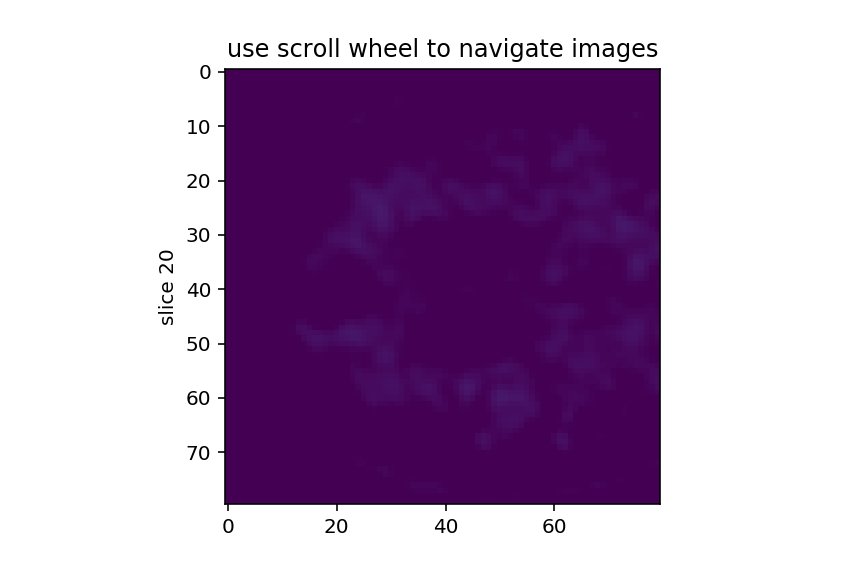

In [18]:
#Enables interactions Z-direction
from __future__ import print_function

%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt


class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, cropped[:,:,:])

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


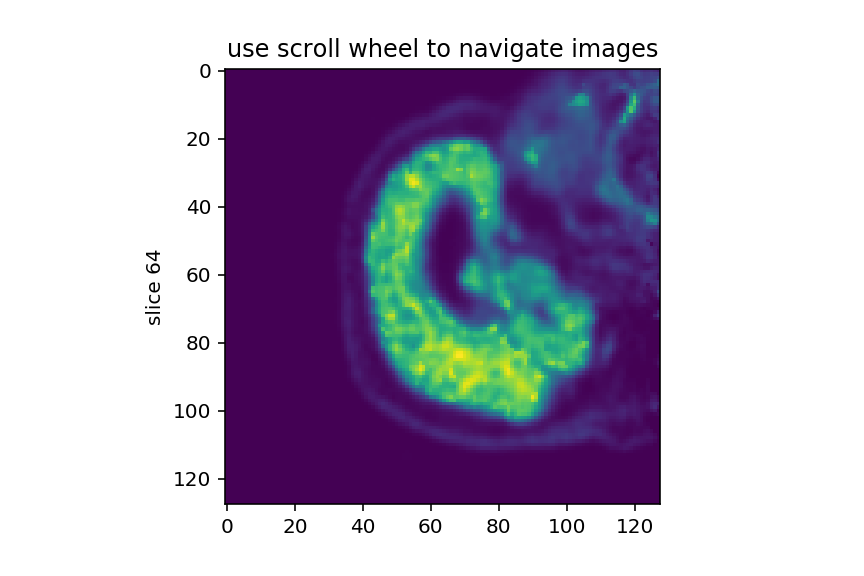

In [18]:
#Enables interactions X-direction
from __future__ import print_function

%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt


class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind,:, :])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind,:, :])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, image1[:,:,:])

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [9]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

0 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
1 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
2 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
3 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
4 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
5 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])
6 torch.Size([4, 128, 128, 128, 1]) torch.Size([4, 6])


In [10]:
sample = dataset.__getitem__(7)
print(torch.mean(sample[0]))
print(sample[0].shape())

tensor(18.6005, dtype=torch.float64)


TypeError: 'torch.Size' object is not callable

In [ ]:
import torchvision
normData =torchvision.transforms.Normalize(Datasest,std=1)

Original shape torch.Size([128, 128, 128])
Rotaded shape (128, 164, 164)
Cropped Shape (128, 164, 100)
Crop Z Shape (128, 164, 75)


Text(0.5, 1.0, "['Patient 1: rCBF (SPECT) slice ', 80]")

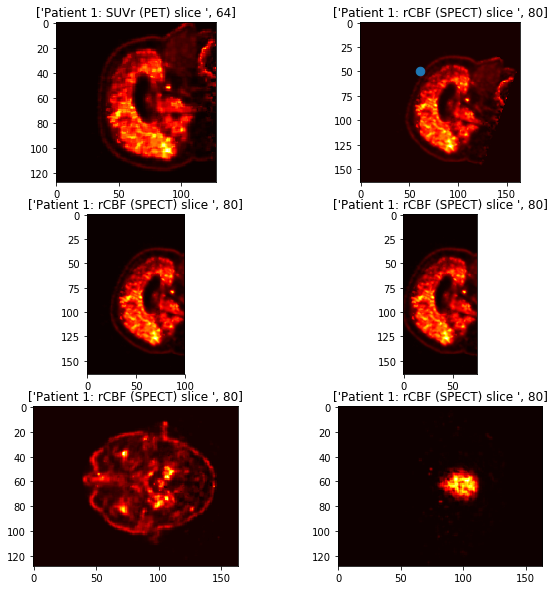

In [111]:
import scipy.ndimage

%matplotlib inline
fig, axs = plt.subplots(3, 2, figsize=(10,10))



sample=datasetCBF.__getitem__(26)
#print(sample[0].size())
image1=np.squeeze(sample[0])
#image2=np.squeeze(sample[0])  

print("Original shape",image1.size())
#ROTATE PIC
imageROT=scipy.ndimage.interpolation.rotate(image1,-20,axes=(1,2))
print("Rotaded shape",imageROT.shape)
#CROP ACCORDING TO CENTRUM

position=np.array([61, 50 ,73])
nrPixelsxy=40
nrPixelsz1=50
z2=25

#Different crops
#cropped  = imageROT[position[0]-nrPixelsxy:position[0]+nrPixelsxy, position[1]-nrPixelsxy:position[1]+nrPixelsxy, position[2]-nrPixelsz:position[2]+nrPixelsz]
croppedz=imageROT[:,:,position[2]-nrPixelsz:position[2]+(nrPixelsz)]
croppedz1=imageROT[:,:,position[2]-z2:position[2]+(nrPixelsz)]

print("Cropped Shape",croppedz.shape)
print("Crop Z Shape",croppedz1.shape)


sliceNr1=64
sliceNr2=80
                        
axs[0, 0].imshow(image1[60,:,:],cmap='hot') #SUVr 
axs[0, 0].set_title(['Patient 1: SUVr (PET) slice ', sliceNr1])
axs[0,1].scatter(61,50,73)
axs[0, 1].imshow(imageROT[60,:,:],cmap='hot') #SUVr
axs[0, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[1, 0].imshow(croppedz[60,:,:],cmap='hot') #SUVr
axs[1, 0].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[1, 1].imshow(croppedz1[60,:,:],cmap='hot') #SUVr
axs[1, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[2, 0].imshow(croppedz1[:,:,-1],cmap='hot') #SUVr
axs[2, 0].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[2, 1].imshow(croppedz1[:,:,0],cmap='hot') #SUVr
axs[2, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])

torch.Size([128, 128, 128, 1])
torch.Size([128, 128, 128, 1])
SUV Rotaded shape (128, 164, 164)
CBF Rotaded shape (128, 164, 164)
[61 72 94]


Text(0.5, 1.0, "['Patient 1: rCBF (SPECT) slice ', 64]")

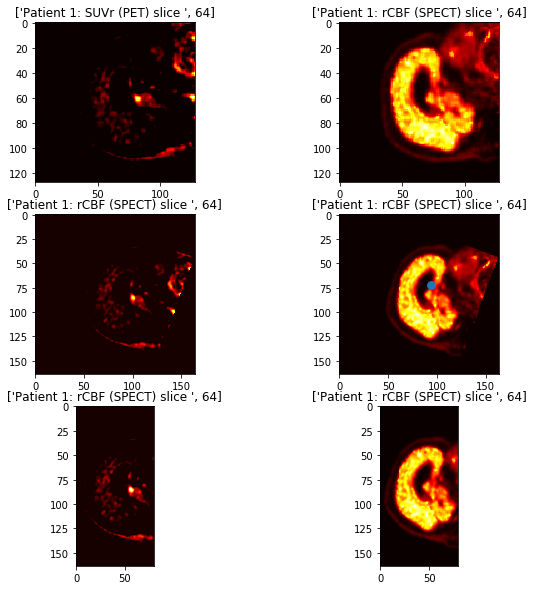

In [234]:
import scipy.ndimage
import matplotlib.pyplot as plt
%matplotlib inline
bild=1
#GET BOTH SAMPLES 
sampleSUV=datasetSUV.__getitem__(bild)
sampleCBF=datasetCBF.__getitem__(bild)
print(sampleSUV[0].size())
print(sampleCBF[0].size())

#Shrink Dim
imageSUV=np.squeeze(sampleSUV[0])
imageCBF=np.squeeze(sampleCBF[0])

#Rotate to align brain
imageSUV_rot=scipy.ndimage.interpolation.rotate(imageSUV,-20,axes=(1,2))
imageCBF_rot=scipy.ndimage.interpolation.rotate(imageCBF,-20,axes=(1,2))
print("SUV Rotaded shape",imageSUV_rot.shape)
print("CBF Rotaded shape",imageCBF_rot.shape)

#Extract positions over threshold
if(bild==22 or bild ==20):
    pixel_threshold=0.35
else:
    pixel_threshold=0.1

val = np.max(imageSUV_rot[:,:,0:100]) -np.max(imageSUV_rot[:,:,0:100])*pixel_threshold
postemp = np.where(imageSUV_rot[:,:,0:100] > val )
x=postemp[0][:]
y=postemp[1][:]
z=postemp[2][:]

#Get middle position of the two balls
#Locate x-position
threshold = (np.max(x)+np.min(x))/2
index= x<= threshold
xmid=(np.mean(x[index])+np.mean(x[~index]))/2
ymid=np.mean(y).astype(int)
zmid=np.mean(z).astype(int)

#Point between balls
position=np.array([xmid,ymid,zmid]).astype(int)
print(position)

#Cropp according to position of striatum middle point(ignoring cropping in x & y)
nrPixelsz=30
z2=50
SUV_cropped=imageSUV_rot[:,:,position[2]-z2:position[2]+nrPixelsz]
CBF_cropped=imageCBF_rot[:,:,position[2]-z2:position[2]+nrPixelsz]

%matplotlib inline
fig, axs = plt.subplots(3, 2, figsize=(10,10))
sliceNr1=64
sliceNr2=64

axs[0, 0].imshow(imageSUV[64,:,:],cmap='hot') #SUVr 
axs[0, 0].set_title(['Patient 1: SUVr (PET) slice ', sliceNr1])

axs[0, 1].imshow(imageCBF[64,:,:],cmap='hot') #SUVr
axs[0, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])

axs[1,1].scatter(position[2],position[1],position[0])
axs[1, 0].imshow(imageSUV_rot[64,:,:],cmap='hot') #SUVr
axs[1, 0].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])

axs[1, 1].imshow(imageCBF_rot[64,:,:],cmap='hot') #SUVr
axs[1, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[2, 0].imshow(SUV_cropped[64,:,:],cmap='hot') #SUVr
axs[2, 0].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])
axs[2, 1].imshow(CBF_cropped[64,:,:],cmap='hot') #SUVr
axs[2, 1].set_title(['Patient 1: rCBF (SPECT) slice ', sliceNr2])


In [ ]:

8 -icke roterad FORT FUCKED

20  BARA PUNKTER PÅ 1 SIDA
22 BARA PUNKTER PÅ 1 SIDA 

In [229]:
postemp

(array([54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56,
        56, 72, 72, 73, 73, 73, 73, 73]),
 array([72, 73, 73, 74, 74, 71, 72, 72, 73, 73, 74, 74, 75, 71, 72, 73, 73,
        74, 74, 75, 73, 74, 75, 76, 76]),
 array([99, 98, 99, 98, 99, 99, 98, 99, 98, 99, 98, 99, 98, 99, 99, 98, 99,
        99, 99, 99, 99, 99, 99, 98, 99]))

(0, 128)

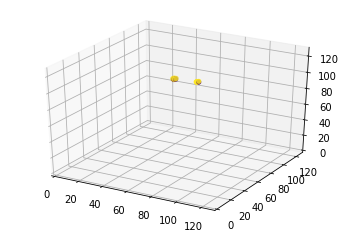

In [230]:
#print(np.shape(position))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(postemp[0],postemp[1],postemp[2], c=z, cmap='viridis', linewidth=0.5);
ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)

In [175]:
a=np.arange(27).reshape(3,3,3)
print(a)
print("hej",a[:,:,0:2])

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]]
hej [[[ 0  1]
  [ 3  4]
  [ 6  7]]

 [[ 9 10]
  [12 13]
  [15 16]]

 [[18 19]
  [21 22]
  [24 25]]]
